In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

import pandas as pd

# Pytorch
import torch
torch.manual_seed(29)
from torch import nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn.parallel
cudnn.benchmark = True
import torchvision.transforms as transforms

from twrap.utils import model_summary, tensor_to_torch_var
from utils.models import *
from torch.utils.data import DataLoader
from utils.datasets import dataset, test_dataset_visob, TestSampler2, test_dataset_2, test_dataset
from twrap.transform import ToZNorm

from twrap.utils import genROC

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from glob import glob

from skimage import transform as T

from sklearn.metrics import roc_curve


class localMatch(object):
    def __init__(self, w = 3, p = 70, cuda = True):
        
        self.w = w
        self.p = p
        c1 = np.zeros([w**2, 1, w, w], dtype = np.float32)
        c = 0
        for i in range(w):
            for j in range(w):
                c1[c, :, i, j] = 1
                c += 1
        c2 = np.zeros([1, 1, w, w], dtype = np.float32)
        c2[:, :, w//2, w//2] = 1
        
        self.c1 = torch.from_numpy(c1)
        self.c2 = torch.from_numpy(c2)
        
        if cuda:
            self.c1 = self.c1.cuda()
            self.c2 = self.c2.cuda()
    
    def __call__(self, I1, I1a, I2, I2a):
        
        I1ap = np.percentile(I1a.data.cpu().numpy(), self. p)
        I2ap = np.percentile(I2a.data.cpu().numpy(), self. p)
        
        I1a = (I1a >= I1ap).float()
        I2a = (I2a >= I2ap).float()
        
        b, f, h, w = I1.size()
        
        new_h = h - self.w + 1
        new_w = w - self.w + 1
        
        I1 = I1.view(b*f, 1, h, w)
        I1 = nn.functional.conv2d(I1, self.c2)
        I1 = I1.view(b, f, 1, new_h, new_w)
        
        I2 = I2.view(b*f, 1, h, w)
        I2 = nn.functional.conv2d(I2, self.c1)
        I2 = I2.view(b, f, self.w**2, new_h, new_w)
        
        I1a = nn.functional.conv2d(I1a, self.c2)
        
        I2a = nn.functional.conv2d(I2a, self.c1)
        
        I1I2 = (I1 * I2).sum(1)
        I1aI2a = I1a * I2a
        
        I1I2 = torch.max((I1I2 * I1aI2a), dim = 1)[0]
        
        I1I2 = I1I2.view(b, -1).sum(1, keepdim = True)
        I1a = I1a.view(b, -1).sum(1, keepdim = True)
        
        return I1I2/I1a

class DenselocalMatch(object):
    def __init__(self, w = 3, p = 70, cuda = True):
        
        self.w = w
        self.p = p
        c1 = np.zeros([w**2, 1, w, w], dtype = np.float32)
        c = 0
        for i in range(w):
            for j in range(w):
                c1[c, :, i, j] = 1
                c += 1
        c2 = np.zeros([1, 1, w, w], dtype = np.float32)
        c2[:, :, w//2, w//2] = 1
        
        self.c1 = torch.from_numpy(c1)
        self.c2 = torch.from_numpy(c2)
        
        if cuda:
            self.c1 = self.c1.cuda()
            self.c2 = self.c2.cuda()
    
    def __call__(self, I1, I2):
        
        
        b, f, h, w = I1.size()
        
        new_h = h - self.w + 1
        new_w = w - self.w + 1
        
        I1 = I1.view(b*f, 1, h, w)
        I1 = nn.functional.conv2d(I1, self.c2)
        I1 = I1.view(b, f, 1, new_h, new_w)
        
        I2 = I2.view(b*f, 1, h, w)
        I2 = nn.functional.conv2d(I2, self.c1)
        I2 = I2.view(b, f, self.w**2, new_h, new_w)

        I1I2 = (I1 * I2).sum(1)
        
        I1I2 = torch.max(I1I2, dim = 1)[0]
        
        I1I2 = I1I2.view(b, -1).mean(1, keepdim = True)
        
        return I1I2

transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(144),
    transforms.CenterCrop(128),
    ToZNorm()
    ])

In [4]:
I1 = transform(Image.open('/media/narsi/fast_drive/CCRops/visob/imgs/EC_VISIT_1/IPHONE/dark/S1/1144_l_2.png'))
I2 = transform(Image.open('/media/narsi/fast_drive/CCRops/visob/imgs/EC_VISIT_1/IPHONE/dark/S1/1144_l_5.png'))


input_var = tensor_to_torch_var(I1.unsqueeze(0), True)
f11, f12, a11, a12 = model.getLocalFeat(input_var)
del input_var
input_var = tensor_to_torch_var(I2.unsqueeze(0), True)
f21, f22, a21, a22 = model.getLocalFeat(input_var)
del input_var

In [7]:
b, f, h, w = f11.size()

In [10]:
a11 = a11.view(b, 1, -1)

In [11]:
_, a11_idx = a11.sort(dim = -1, descending = True)

In [8]:
class extract_features(object):
    def __init__(self, topk = 256, feat_size = (32, 32)):
        self.topk = topk
        
        self.locs = torch.from_numpy(np.zeros((2, feat_size[0]* feat_size[1]), dtype = np.int64))
            
        c = 0
        for i in range(feat_size[0]):
            for j in range(feat_size[1]):
                self.locs[0, c] = i
                self.locs[1, c] = j
                c += 1
        
    def __call__(self, feat, atten):
        
        b, f, h, w = feat.size()
        
        atten = atten.view(b, 1, -1)
        _, atten_idx = atten.sort(dim = -1, descending = True)
        
        feat = feat.view(b, f, -1)
        
        feat_loc = torch.zeros(b, 2, self.topk).long()
        
        for i in range(b):
            feat[i, :, :] = feat[i, :, atten_idx[i, 0, :]]
            feat_loc[i, :, :] = self.locs[:, atten_idx[i, 0, :self.topk]]
        
        return feat, feat_loc

In [9]:
EF = extract_features(topk = 256, feat_size = (32, 32))

In [10]:
feat, feat_loc = EF(f11.data.cpu(), a11.data.cpu())

In [ ]:
def gen_and_save_features(visit, device, light, eye, dst_fldr):
    src_fldr = '/media/narsi/fast_drive/CCRops/visob/imgs/'+visit+'/'+device+'/'+light
    imgs = glob(src_fldr1 + os.sep + 'S1' + os.sep + '*_'+eye+'_*.png')
    
    dataset = test_dataset(e_imgs, v_imgs, transform)
    dataset_loader = DataLoader(dataset, num_workers=8, pin_memory=True, 64)

In [2]:
def gen_and_save_scores(visit1, visit2, device, light_enroll, light_verify, eye, dst_fldr):
    src_fldr1 = '/media/narsi/fast_drive/CCRops/visob/imgs/'+visit1+'/'+device+'/'+light_enroll
    src_fldr2 = '/media/narsi/fast_drive/CCRops/visob/imgs/'+visit2+'/'+device+'/'+light_verify

    e_imgs = glob(src_fldr1 + os.sep + 'S1' + os.sep + '*_'+eye+'_*.png')
    v_imgs = glob(src_fldr2 + os.sep + 'S2' + os.sep + '*_'+eye+'_*.png')

    dataset = test_dataset_2(e_imgs, v_imgs, transform)
    dataset_loader = DataLoader(dataset, num_workers=8, pin_memory=True, batch_sampler = TestSampler2(dataset.num_enroll, dataset.num_verify, 64))

    LM_3_50 = localMatch(w = 3, p = 50)
    LM_3_70 = localMatch(w = 3, p = 70)
    LM_3_90 = localMatch(w = 3, p = 90)

    LM_7_50 = localMatch(w = 7, p = 50)
    LM_7_70 = localMatch(w = 7, p = 70)
    LM_7_90 = localMatch(w = 7, p = 90)

    LM_3 = DenselocalMatch(w = 3)
    LM_7 = DenselocalMatch(w = 7)

    scores = []
    e_labels = []
    v_labels = []
    v_names = []
    
    for (Ie, Iv, sie, siv, imgv) in tqdm(dataset_loader):
        
        input_var = tensor_to_torch_var(Ie, True)
        f11, f12, a11, a12 = model.getLocalFeat(input_var)
        del input_var
        input_var = tensor_to_torch_var(Iv, True)
        f21, f22, a21, a22 = model.getLocalFeat(input_var)
        del input_var

        s350 = LM_3_50(f12, a12, f22, a22).data.cpu().numpy()
        s370 = LM_3_70(f12, a12, f22, a22).data.cpu().numpy()
        s390 = LM_3_90(f12, a12, f22, a22).data.cpu().numpy()

        s750 = LM_7_50(f11, a11, f21, a21).data.cpu().numpy()
        s770 = LM_7_70(f11, a11, f21, a21).data.cpu().numpy()
        s790 = LM_7_90(f11, a11, f21, a21).data.cpu().numpy()

        s3 = LM_3(f12, f22).data.cpu().numpy()
        s7 = LM_7(f11, f21).data.cpu().numpy()

        scores.append(np.concatenate([s350, s370, s390, s750, s770, s790, s3, s7], 1))

        e_labels += sie
        v_labels += siv
        v_names += imgv

        del f11, f12, a11, a12, f21, f22, a21, a22, s350, s370, s390, s750, s770, s790, s3, s7
        

    scores = np.concatenate(scores)
    e_labels = np.asarray(e_labels, dtype = np.object)
    v_labels = np.asarray(v_labels, dtype = np.object)
    v_names = np.asarray(v_names, dtype = np.object)
    
    dst_data_fldr = os.path.join(dst_fldr, visit1+'__'+visit2, device, 
                                light_enroll + '__' + light_verify + '__' + eye + '.npz')
    
    if not os.path.exists(os.path.split(dst_data_fldr)[0]):
        os.makedirs(os.path.split(dst_data_fldr)[0])
        
    np.savez_compressed(dst_data_fldr, scores = scores, e_labels = e_labels, v_labels = v_labels, v_names = v_names)

In [3]:
weights_dir = '/media/narsi/LargeData/SP2019/ocularnetv2.1/SPHERE/MODEL1/weights'

model_instance_name = 'MODEL2_ATTEN1_SPH_COMB_C128_SALL_ROT20_SCALE80-100_BLUR0-1.5_COLORJIT'#

model = MODEL2(400, classify = False, attention = True)
check_point_file = weights_dir+ os.sep +model_instance_name + '/model_best.pth.tar'
checkpoint = torch.load(check_point_file, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])
model.cuda()
model.eval()
print('.')

.


In [4]:
dst_fldr = '/media/narsi/LargeData/ocularnetv2_2019_SUMMER'

In [5]:
for visit1 in ['EC_VISIT_1', 'EC_VISIT_2']:
    for visit2 in ['EC_VISIT_1', 'EC_VISIT_2']:
        for device in ['IPHONE', 'NOTE4', 'OPPO']:
            for light_enroll in ['office', 'dark', 'daylight']:
                for light_verify in ['office', 'dark', 'daylight']:
                    for eye in ['l', 'r']:
                        gen_and_save_scores(visit1, visit2, device, light_enroll, light_verify, eye, dst_fldr)

 27%|██▋       | 36906/136674 [1:17:49<3:35:13,  7.73it/s]

KeyboardInterrupt: 

In [3]:
import numpy as np

In [19]:
x = []
for i in range(5):
    for j in range(5):
        x.append([i, j])
x = np.asarray(x)

In [20]:
np.sum(np.abs(x - x[12:13, :]), axis = -1)

array([4, 3, 2, 3, 4, 3, 2, 1, 2, 3, 2, 1, 0, 1, 2, 3, 2, 1, 2, 3, 4, 3,
       2, 3, 4])

In [21]:
import torch

In [50]:
X = torch.randn(32, 128, 32*32)
Y = torch.randn(32, 1, 32*32)
_, idx = Y.sort(dim = -1, descending = True)

In [59]:
for i in range(32):
    X[i, :, :] = X[i, :, idx[i, 0, :]]

In [58]:
y[:, 0, idx[..., 256]].shape

torch.Size([32, 32, 1])

In [39]:
x = (X>val)

In [40]:
feat = torch.masked_select(X, x)

In [41]:
feat.size()

torch.Size([1038751])

In [42]:
1038751/128

8115.2421875

In [49]:
x = torch.gather(X, dim = 0, index = idx)

RuntimeError: Expected tensor [32, 1, 1024], src [32, 128, 1024] and index [32, 1, 1024] to have the same size apart from dimension 0

In [18]:
X = np.load('/media/narsi/LargeData/ocularnetv2_2019_SUMMER/SCORES_W16_P64/EC_VISIT_1__EC_VISIT_1/IPHONE/office__dark__l.npz')

In [19]:
scores = X['scores']
enroll = X['enroll']
verify = X['verify']

In [20]:
targets = 1 * (enroll == verify)

In [21]:
far, tar, _ = roc_curve(1 * (enroll == verify), scores)

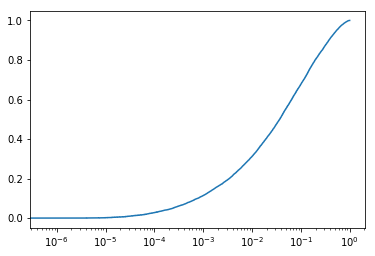

In [22]:
plt.semilogx(far, tar)

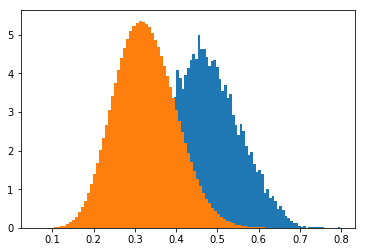

In [23]:
x = plt.hist(scores[targets == 1], bins = 100, density=True)
y = plt.hist(scores[targets == 0], bins = 100, density=True)

In [17]:
np.max(tar[far <= 0.0001])

0.4306424024899756